# Intuitive explanation of least-squares estimation of vector autoregression

Are you one of those who have seen the least-squares estimator $\hat{\beta} = (X´X)^{-1} X´Y$ a thousand times but neven really fully understood what it means? Or matrix dimensions in equations give you a headache?

You've come to the right place! In this notebook we build a solid intuitive understanding what it means to estimate a vector-autoregression (VAR) model using least-squares. 

To do
 - Proof of the least-squares estimation needs to be elaborated.

Notebok by @VilleEcon.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from statsmodels.stats.moment_helpers import corr2cov
pd.options.display.max_rows = 6
pd.set_option("display.precision", 2)
np.random.seed(seed=1337)

Let $\{y_{i, t} \}_{t=0}^T$ (notice index start at $t=0$!) denote a one-dimensional time series of length $\bar{T} = T + 1$. A collection of N time series $\{y_{1, t}, ... , y_{N, t} \}_{t=0}^T$ can be written as $y_t$, $t=0,...,T$. Each $y_t$ is thus a $1xN$ vector. Let's generate sampe data $y_t$ over $t=0,...,T=299$ for two variables, which will be a $\bar{T} \times N$ dataframe.

Here are the full time series over t=0,...,299:


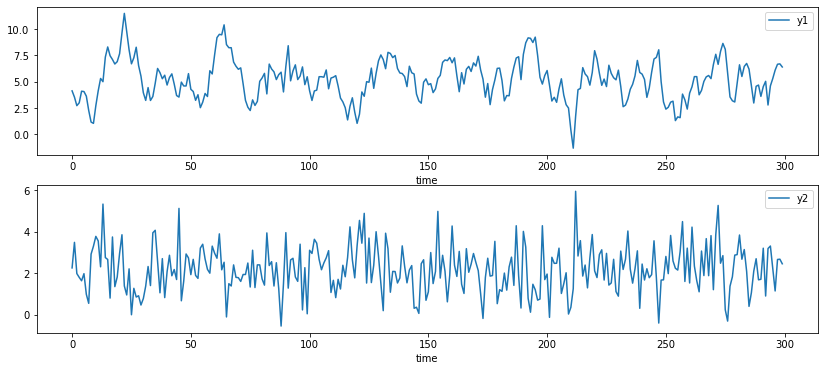

In [2]:
# Model parameters
N = 2
T = 299
intercepts = np.array([0, 3])
coefs = np.array([
       [0.8, 0.5], 
       [-0.2, 0.1],
]).flatten(order="C")
corr = np.array([
    [1, 0.2],
    [0.2, 1],
])
stds = [1, 1]
endog = np.array([[None,  None]])

# VAR model object
mod1 = sm.tsa.VARMAX(endog, order=(1, 0))

# Transform corerlation to covariance
cov = corr2cov(corr, stds)

# Simulate data
params = np.concatenate([intercepts, coefs, cov[np.triu_indices(cov.shape[1])]], axis=0)
df = pd.DataFrame(mod1.simulate(params, T+1), columns=["y1", "y2"])
df.index.name = "time"

# Display data
print("Here are the full time series over t=0,...,{}:".format(T))
fig = plt.figure(figsize=(14, 6))
for idx, col in enumerate(df.columns):
    ax = fig.add_subplot(len(df.columns), 1, idx+1)
    df[[col]].plot(ax=ax)

In [3]:
print("Data as a table looks like this:")
display(df)

Data as a table looks like this:


,y1,y2
time,,
0,4.14,2.26
1,3.54,3.49
2,2.73,1.99
...,...,...
297,6.67,2.67
298,6.70,2.68
299,6.41,2.46


Variables $y_t, y_{t-1}, ..., y_{t-p}$ for given $t$ (say $t=2$) and e.g. $p=2$ look like

In [4]:
crt_time = 2
display(df.loc[[crt_time]])
display(df.loc[[crt_time-1]])
display(df.loc[[crt_time-2]])

,y1,y2
time,,
2,2.73,1.99


,y1,y2
time,,
1,3.54,3.49


,y1,y2
time,,
0,4.14,2.26


A $VAR(p)$ model reads

$$
\begin{align*}
y_{t} & = y_{t-1} \beta_1 + \cdots + y_{t-p} \beta_{p} + u_{t} \quad , \ t=p, ... , T,
\end{align*}
$$

where $'$ denotes transpose, $\beta_i$ are $NxN$ parameter matrices and $u_t$ is a $1xN$ vector of errors.

This means that in example case with $p=2$ the VAR equation at  $t=2$ would look like

$$
\begin{align*}
\begin{bmatrix} 2.73 & 1.99 \end{bmatrix} & = \begin{bmatrix} 3.54 & 3.49 \end{bmatrix} \begin{bmatrix} \beta_{1,11} & \beta_{1,12} \\ \beta_{1,21} & \beta_{1,22} \end{bmatrix} + \begin{bmatrix} 4.14 & 2.62 \end{bmatrix} \begin{bmatrix} \beta_{2,11} & \beta_{2,12} \\ \beta_{2,21} & \beta_{2,22} \end{bmatrix} + \begin{bmatrix} u_{2, 1} & u_{2, 2} \end{bmatrix}
\end{align*}
$$

Now for each $t$ define a $1 \times Np$ vector

$$z_t \equiv \begin{bmatrix} y_t & y_{t-1} & ... & y_{t-p+1} \end{bmatrix}$$

Further define a $Np \times N$ matrix

$$A \equiv \begin{bmatrix} \beta_1 \\ \beta_2 \\ \vdots \\ \beta_p \end{bmatrix} $$

With these we can write the VAR(p) more compactly as

$$
\begin{align*}
y_{t} & = z_{t-1} A + u_{t} \quad , \ t=p, ... , T,
\end{align*}
$$

In our example case at time period $t=2$, $z_{t-1} = z_{1}$ looks like

In [5]:
p = 2
t = 2
z_1 = pd.DataFrame(df.loc[t-1-p:t-1].sort_index(ascending=False).values.flatten(order="C")).T
z_1.columns = ["y_1_1", "y_1_2", "y_0_1", "y_0_2"]
z_1

,y_1_1,y_1_2,y_0_1,y_0_2
0,3.54,3.49,4.14,2.26


Thus the above regression equation looks like

$$
\begin{bmatrix}
2.73 & 1.99
\end{bmatrix}
=
\begin{bmatrix} 3.54 & 3.49 & 4.14 & 2.62 \end{bmatrix}
\begin{bmatrix}
\beta_{1,11} & \beta_{1,21} \\
\beta_{1,12} & \beta_{1,22} \\
\beta_{2,11} & \beta_{2,21} \\
\beta_{2,12} & \beta_{2,22} \\
\end{bmatrix}
+
\begin{bmatrix} u_{t, 1} & u_{t, 2} \end{bmatrix}
$$

Now we stack the matrices with all time observations. Let $\tilde{T} \equiv \bar{T}- p$ and define a $\tilde{T} \times N$ matrix

$$Y \equiv \begin{bmatrix} y_{p} \\ y_{p+1} \\ \vdots \\ y_T \end{bmatrix}$$

and a $\tilde{T} \times Np$ matrix

$$Z = \begin{bmatrix} z_{p-1} \\ z_{p} \\ \vdots \\ z_{T-1} \end{bmatrix}$$

In case $p=2$, $Y$ is just our original data frame (except of length $\tilde{T}$ instead of $\bar{T}$ as first $p$ observations are dropped):

In [6]:
Y = df.loc[2:].copy()
Y.index = ["y_"+str(x) for x in Y.index]
Y

,y1,y2
y_2,2.73,1.99
y_3,3.00,1.81
y_4,4.11,1.64
...,...,...
y_297,6.67,2.67
y_298,6.70,2.68
y_299,6.41,2.46


On the other hand, $Z$ looks like

In [7]:
Z = pd.DataFrame()
for locator in range(t, T+1):
    gg = pd.DataFrame(df.loc[locator-p:locator-1].sort_index(ascending=False).values.flatten(order="C")).T
    Z = Z.append(gg, ignore_index=True)
Z.index = ["z_"+str(x) for x in range(t-1, T)]
Z

,0,1,2,3
z_1,3.54,3.49,4.14,2.26
z_2,2.73,1.99,3.54,3.49
z_3,3.00,1.81,2.73,1.99
...,...,...,...,...
z_296,6.11,1.15,5.31,2.24
z_297,6.67,2.67,6.11,1.15
z_298,6.70,2.68,6.67,2.67


The VAR(p) equation can now be written as

$$
\begin{align*}
Y & = Z A + U \ ,
\end{align*}
$$

with $\tilde{T} \times N$ matrix of errors $U \equiv \begin{bmatrix} u_{p+1} \\ u_{p+2} \\ \vdots \\ u_T \end{bmatrix} $.

In the example case with $p=2$ this equation looks like

$$
\begin{bmatrix} 2.73 & 1.99 \\ \vdots & \vdots \\ 6.41 & 2.46 \end{bmatrix} = 
\begin{bmatrix} 3.54 & 3.49 & 4.14 & 2.26 \\ \vdots & \vdots & \vdots & \vdots & \\ 6.70 & 2.68 & 6.67 & 2.67 \end{bmatrix}
 \begin{bmatrix}
\beta_{1,11} & \beta_{1,21} \\
\beta_{1,12} & \beta_{1,22} \\
\beta_{2,11} & \beta_{2,21} \\
\beta_{2,12} & \beta_{2,22}\end{bmatrix} +
\begin{bmatrix} u_{2, 1} & u_{2, 2} \\ \vdots & \vdots \\ u_{299, 1} & u_{299, 2} \end{bmatrix}
$$

How do we get from the above regression equation to the least-squares estimator of $A$, namely $Np \times N$ matrix $\hat{A}$? Least-squares estimate $\hat{A^*}$ is a solution to above equation that minimizes squared residuals $u_t^2, \ t=p,... , T$. That is, the least-squares estimator is

$$\hat{A} = \underset{A}{\operatorname{argmin}} \ \sum_{t=p}^T (y_t - z_t A)^2$$

or equivalently

$$\hat{A} = \underset{A}{\operatorname{argmin}} \ \mathbf{1}' \ ( (Y - Z A) \otimes (Y - Z A)) $$

where $\mathbf{1}$ is a $\tilde{T} \times 1$ vector of ones and $\otimes$ denotes element-wise product, or Hadamart product (multiplication by $\mathbf{1}'$ takes columns sums).

It can be shown (Hamilton (1994) pages 74 and 201) that the least square estimate $\hat{A^*}$ is one that

$$
\begin{align*}
& \hat{A^*} = (Z' Z)^{-1} Z'Y
\end{align*}
$$

In our example case $(Z'Z)^{-1}$ looks like

In [8]:
pd.set_option("display.precision", 6)
ZZ_inv = pd.DataFrame(np.linalg.inv(np.matmul(Z.T.values, Z.values)))
ZZ_inv.style.hide_index()

0,1,2,3
0.003521,-0.000328,-0.002841,-0.001357
-0.000328,0.001921,-0.000047,-0.000841
-0.002841,-0.000047,0.002669,0.000659
-0.001357,-0.000841,0.000659,0.002662


and $Z'Y$ looks like

In [9]:
pd.set_option("display.precision", 6)
ZY = pd.DataFrame(np.matmul(Z.T.values, Y.values))
ZY.style.hide_index()

0,1
8983.415971,3209.104556
3520.124127,1473.057513
8760.494090,3207.256448
3513.435793,1445.399675


so that finally $\hat{A^*}$ is 

In [10]:
A_est = pd.DataFrame(np.matmul(ZZ_inv.values, ZY.values))
A_est.style.hide_index()

0,1
0.820257,-0.256963
0.444413,0.409159
0.009576,0.326174
-0.029503,0.365929


## Appendix

### Check estimates

In [11]:
# VAR
model_var = sm.tsa.VAR(df)
res_var = model_var.fit(maxlags=2, trend="nc")
res_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Jan, 2022
Time:                     19:05:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.515774
Nobs:                     298.000    HQIC:                  0.456253
Log likelihood:          -899.749    FPE:                    1.51668
AIC:                     0.416523    Det(Omega_mle):         1.47677
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
L1.y1         0.820257         0.058681           13.978           0.000
L1.y2         0.444413         0.043343           10.253           0.000
L2.y1         0.009576         0.051093            0.187           0.851
L2.y2        -0.029503